In [13]:
%matplotlib inline
import sys
BIN = '../../'
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import my_matplotlib_style as ms
import matplotlib as mpl
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

from fastai import data_block, basic_train, basic_data
import fastai

In [14]:
from my_nn_modules import AE_basic, AE_bn, AE_LeakyReLU, AE_bn_LeakyReLU

In [15]:
# Load data
#train = pd.read_pickle(BIN + 'processed_data/aod/partial_train.pkl')
#test = pd.read_pickle(BIN + 'processed_data/aod/partial_test.pkl')

#train = pd.read_pickle(BIN + 'processed_data/aod/full_train.pkl')
#test = pd.read_pickle(BIN + 'processed_data/aod/full_test.pkl')

#train = pd.read_pickle(BIN + 'processed_data/aod/all_jets_partial_train.pkl')
#test = pd.read_pickle(BIN + 'processed_data/aod/all_jets_partial_test.pkl')

train = pd.read_pickle(BIN + 'processed_data/aod/all_jets_partial_train_10percent.pkl')
print(train.shape)
test = pd.read_pickle(BIN + 'processed_data/aod/all_jets_partial_test_10percent.pkl')

#train = pd.read_pickle(BIN + 'processed_data/aod/all_jets_full_train.pkl')
#test = pd.read_pickle(BIN + 'processed_data/aod/all_jets_full_test.pkl')

train['pt'] = train['pt'] / 1000.  # Convert to GeV
test['pt'] = test['pt'] / 1000.  # Convert to GeV
train['m'] = train['m'] / 1000.  # Convert to GeV
test['m'] = test['m'] / 1000.  # Convert to GeV

train['LeadingClusterPt'] = train['LeadingClusterPt'] / 1000.  # Convert to GeV
test['LeadingClusterPt'] = test['LeadingClusterPt'] / 1000.  # Convert to GeV

train['LeadingClusterSecondR'] = train['LeadingClusterSecondR'] / 1000.  # Convert to GeV
test['LeadingClusterSecondR'] = test['LeadingClusterSecondR'] / 1000.  # Convert to GeV

train['LeadingClusterSecondLambda'] = train['LeadingClusterSecondLambda'] / 1000.  # Convert to GeV
test['LeadingClusterSecondLambda'] = test['LeadingClusterSecondLambda'] / 1000.  # Convert to GeV

train['NegativeE'] = train['NegativeE'] / 1000.  # Convert to GeV
test['NegativeE'] = test['NegativeE'] / 1000.  # Convert to GeV

train.pop('JetGhostArea')
test.pop('JetGhostArea')
train.pop('BchCorrCell')
test.pop('BchCorrCell')

#train.pop('ActiveArea')
#test.pop('ActiveArea')
#train.pop('ActiveArea4vec_pt')
#test.pop('ActiveArea4vec_pt')
#train.pop('N90Constituents')
#test.pop('N90Constituents')


# Remove all jets with EMFrac outside (-2, 2)
train = train[(np.abs(train['EMFrac']) < 5)]
test = test[(np.abs(test['EMFrac']) < 5)]

train = train[np.invert((np.abs(train['EMFrac']) < 0.05) & (np.abs(train['eta']) >= 2))]
test = test[np.invert((np.abs(test['EMFrac']) < 0.05) & (np.abs(test['eta']) >= 2))]

train = train[np.invert((train['AverageLArQF'] > .8) & (train['EMFrac'] > .95) & (train['LArQuality'] > .8) & (np.abs(train['eta']) < 2.8))]
test = test[np.invert((test['AverageLArQF'] > .8) & (test['EMFrac'] > .95) & (test['LArQuality'] > .8) & (np.abs(test['eta']) < 2.8))]

train = train[np.abs(train['NegativeE']) < 60 * 5]
test = test[np.abs(test['NegativeE']) < 60 * 5]

# Filter out extreme jets
train = train[np.invert((train['AverageLArQF'] > .8) & (np.abs(train['HECQuality']) > 0.5) & (np.abs(train['HECFrac']) > 0.5))]
test = test[np.invert((test['AverageLArQF'] > .8) & (np.abs(test['HECQuality']) > 0.5) & (np.abs(test['HECFrac']) > 0.5))]

train = train[train['OotFracClusters10'] > -0.1]
test = test[test['OotFracClusters10'] > -0.1]
train = train[train['OotFracClusters5'] > -0.1]
test = test[test['OotFracClusters5'] > -0.1]

train = train[np.abs(train['Width']) < 5]
test = test[np.abs(test['Width']) < 5]

train = train[np.invert(train['Width'] == -1)]
test = test[np.invert(test['Width'] == -1)]

train = train[np.abs(train['WidthPhi']) < 5]
test = test[np.abs(test['WidthPhi']) < 5]
          
train = train[np.abs(train['Timing']) < 125]
test = test[np.abs(test['Timing']) < 125]

train = train[train['LArQuality'] < 4]
test = test[test['LArQuality'] < 4]

train = train[np.abs(train['HECQuality']) < 2.5]
test = test[np.abs(test['HECQuality']) < 2.5]

#train = train[train['m'] > 0]
#test = test[test['m'] > 0]

# train = train[train['m'] > 1e-3]
# test = test[test['m'] > 1e-3]

(956154, 29)


In [28]:
for ii, key in enumerate(train.keys()):
    print("'" + str(key) + "': " + "'Difference in " + str(key) + "',")

'pt': 'Difference in pt',
'eta': 'Difference in eta',
'phi': 'Difference in phi',
'm': 'Difference in m',
'ActiveArea': 'Difference in ActiveArea',
'ActiveArea4vec_eta': 'Difference in ActiveArea4vec_eta',
'ActiveArea4vec_m': 'Difference in ActiveArea4vec_m',
'ActiveArea4vec_phi': 'Difference in ActiveArea4vec_phi',
'ActiveArea4vec_pt': 'Difference in ActiveArea4vec_pt',
'AverageLArQF': 'Difference in AverageLArQF',
'NegativeE': 'Difference in NegativeE',
'HECQuality': 'Difference in HECQuality',
'LArQuality': 'Difference in LArQuality',
'Width': 'Difference in Width',
'WidthPhi': 'Difference in WidthPhi',
'CentroidR': 'Difference in CentroidR',
'DetectorEta': 'Difference in DetectorEta',
'LeadingClusterCenterLambda': 'Difference in LeadingClusterCenterLambda',
'LeadingClusterPt': 'Difference in LeadingClusterPt',
'LeadingClusterSecondLambda': 'Difference in LeadingClusterSecondLambda',
'LeadingClusterSecondR': 'Difference in LeadingClusterSecondR',
'N90Constituents': 'Difference in N9

In [19]:
np.sum(train['LeadingClusterCenterLambda'] == 0)

489

In [10]:
np.sum(test['Width'] == 0)

0

In [4]:
np.sum(train['m']==0)

5064

In [5]:
train.shape

(952063, 27)

In [6]:
956154 - 952063

4091

In [7]:
len(train.keys())

27

In [8]:
plt.close('all')

In [9]:
def plot_all(data, logy=False):
    for key in data.keys():
        plt.figure()
        plt.hist(data[key], bins=200)
        plt.xlabel(str(key))
        plt.ylabel('Number of jets')
        if logy:
            plt.yscale('log')
        else:
            ms.sciy()

In [10]:
plt.close('all')

In [11]:
eta_div = 5
emfrac_div = 1.6
negE_div = 1.6
phi_div = 3
m_div = 1.8
width_div = .6
N90_div = 20
timing_div = 40
hecq_div = 1
centerlambda_div = 2
secondlambda_div = 1
secondR_div = .6
larqf_div = 2.5
pt_div = 1.2
centroidR_div = 0.8
area4vecm_div = 0.18
area4vecpt_div = 0.7
area4vec_div = 0.8
Oot_div = 0.3
larq_div = 0.6

log_add = 100
log_sub = 2
m_add = 1
centroidR_sub = 3
pt_sub = 1.3
area4vecm_sub = 0.15
    

def custom_normalization(train, test):
    train_cp = train.copy()
    test_cp = test.copy()
    
    for data in [train_cp, test_cp]:
        data['DetectorEta'] = data['DetectorEta'] / eta_div
        data['ActiveArea4vec_eta'] = data['ActiveArea4vec_eta'] / eta_div
        data['EMFrac'] = data['EMFrac'] / emfrac_div
        data['NegativeE'] = np.log10(-data['NegativeE'] + 1) / negE_div
        data['eta'] = data['eta'] / eta_div
        data['phi'] = data['phi'] / phi_div
        data['ActiveArea4vec_phi'] = data['ActiveArea4vec_phi'] / phi_div
        data['Width'] = data['Width'] / width_div
        data['WidthPhi'] = data['WidthPhi'] / width_div
        data['N90Constituents'] = data['N90Constituents'] / N90_div
        data['Timing'] = data['Timing'] / timing_div
        data['HECQuality'] = data['HECQuality'] / hecq_div
        data['ActiveArea'] = data['ActiveArea'] / area4vec_div
        data['ActiveArea4vec_m'] = data['ActiveArea4vec_m'] / area4vecm_div - area4vecm_sub
        data['ActiveArea4vec_pt'] = data['ActiveArea4vec_pt'] / area4vecpt_div
        data['LArQuality'] = data['LArQuality'] / larq_div

        data['m'] = np.log10(data['m'] + m_add) / m_div
        data['LeadingClusterCenterLambda'] = (np.log10(data['LeadingClusterCenterLambda'] + log_add) - log_sub) / centerlambda_div
        data['LeadingClusterSecondLambda'] = (np.log10(data['LeadingClusterSecondLambda'] + log_add) - log_sub) / secondlambda_div
        data['LeadingClusterSecondR'] = (np.log10(data['LeadingClusterSecondR'] + log_add) - log_sub) / secondR_div
        data['AverageLArQF'] = (np.log10(data['AverageLArQF'] + log_add) - log_sub) / larqf_div
        data['pt'] = (np.log10(data['pt']) - pt_sub) / pt_div
        data['LeadingClusterPt'] = np.log10(data['LeadingClusterPt']) / pt_div
        data['CentroidR'] = (np.log10(data['CentroidR']) - centroidR_sub) / centroidR_div
        data['OotFracClusters10'] = np.log10(data['OotFracClusters10'] + 1) / Oot_div
        data['OotFracClusters5'] = np.log10(data['OotFracClusters5'] + 1) / Oot_div
        
    return train_cp, test_cp


def custom_unnormalize(normalized_data):
    data = normalized_data.copy()
    data['DetectorEta'] = data['DetectorEta'] * eta_div
    data['ActiveArea4vec_eta'] = data['ActiveArea4vec_eta'] * eta_div
    data['EMFrac'] = data['EMFrac'] * emfrac_div
    data['eta'] = data['eta'] * eta_div
    data['phi'] = data['phi'] * phi_div
    data['ActiveArea4vec_phi'] = data['ActiveArea4vec_phi'] * phi_div
    data['Width'] = data['Width'] * width_div
    data['WidthPhi'] = data['WidthPhi'] * width_div
    data['N90Constituents'] = data['N90Constituents'] * N90_div
    data['Timing'] = data['Timing'] * timing_div
    data['HECQuality'] = data['HECQuality'] * hecq_div
    data['ActiveArea'] = data['ActiveArea'] * area4vec_div
    data['ActiveArea4vec_m'] = (data['ActiveArea4vec_m'] + area4vecm_sub) * area4vecm_div
    data['ActiveArea4vec_pt'] = data['ActiveArea4vec_pt'] * area4vecpt_div
    data['LArQuality'] = data['LArQuality'] * larq_div

    data['NegativeE'] = 1 - np.power(10, negE_div * data['NegativeE'])
    data['m'] = np.power(10, m_div * data['m']) - m_add
    data['LeadingClusterCenterLambda'] = np.power(10, centerlambda_div * data['LeadingClusterCenterLambda'] + log_sub) - log_add
    data['LeadingClusterSecondLambda'] = np.power(10, secondlambda_div * data['LeadingClusterSecondLambda'] + log_sub) - log_add
    data['LeadingClusterSecondR'] = np.power(10, secondR_div * data['LeadingClusterSecondR'] + log_sub) - log_add
    data['AverageLArQF'] = np.power(10, larqf_div * data['AverageLArQF'] + log_sub) - log_add
    data['pt'] = np.power(10, pt_div * data['pt'] + pt_sub)
    data['LeadingClusterPt'] = np.power(10, pt_div * data['LeadingClusterPt'])
    data['CentroidR'] = np.power(10, centroidR_div * data['CentroidR'] + centroidR_sub)
    data['OotFracClusters10'] = np.power(10, Oot_div * data['OotFracClusters10']) - 1
    data['OotFracClusters5'] = np.power(10, Oot_div * data['OotFracClusters5']) - 1
    
    return data


    
    
    

In [12]:
custom_normalized_train, custom_normalized_test = custom_normalization(train, test)
unnormalized_test = custom_unnormalize(custom_normalized_test)

In [13]:
def plot_all_pred(data, pred, logy=False, alph=0.8, save=False):
    for i_fig, key in enumerate(data.keys()):
        plt.figure()
        n, bin_edges, _ = plt.hist(data[key], bins=200, color='c', label='Input', alpha=alph)
        plt.hist(pred[key], bins=bin_edges, color='orange', label='Output', alpha=alph)
        plt.legend()
        plt.xlabel(str(key))
        plt.ylabel('Number of jets')
        if logy:
            plt.yscale('log')
        else:
            ms.sciy()
        if save:
            plt.savefig('analysis_figures/fig%d' % i_fig)

In [14]:
plt.close('all')

In [15]:
%matplotlib inline
import sys
BIN = '../../'
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
#import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import my_matplotlib_style as ms
import matplotlib as mpl
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

from fastai import data_block, basic_train, basic_data
import fastai

In [16]:
from my_nn_modules import AE_bn_LeakyReLU

In [17]:
train_ds = TensorDataset(torch.tensor(custom_normalized_train.values, dtype=torch.float), torch.tensor(custom_normalized_train.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(custom_normalized_test.values, dtype=torch.float), torch.tensor(custom_normalized_test.values, dtype=torch.float))

In [18]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [19]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs=1024)

In [20]:
db = basic_data.DataBunch(train_dl, valid_dl)

In [55]:
train.keys()

Index(['pt', 'eta', 'phi', 'm', 'ActiveArea', 'ActiveArea4vec_eta',
       'ActiveArea4vec_m', 'ActiveArea4vec_phi', 'ActiveArea4vec_pt',
       'AverageLArQF', 'NegativeE', 'HECQuality', 'LArQuality', 'Width',
       'WidthPhi', 'CentroidR', 'DetectorEta', 'LeadingClusterCenterLambda',
       'LeadingClusterPt', 'LeadingClusterSecondLambda',
       'LeadingClusterSecondR', 'N90Constituents', 'EMFrac', 'HECFrac',
       'Timing', 'OotFracClusters10', 'OotFracClusters5'],
      dtype='object')

In [58]:
np.min(custom_normalized_train['LArQuality'])

0.0

In [127]:
class AE_bn_LeakyReLU(nn.Module):
    def __init__(self, nodes, no_last_bias=False):
        super(AE_bn_LeakyReLU, self).__init__()
        n_layers = len(nodes)
        ins_n_outs = []
        en_modulelist = nn.ModuleList()
        de_modulelist = nn.ModuleList()
        for ii in range(n_layers // 2):
            ins = nodes[ii]
            outs = nodes[ii + 1]
            ins_n_outs.append((ins, outs))
            en_modulelist.append(nn.Linear(ins, outs))
            en_modulelist.append(nn.LeakyReLU())
            en_modulelist.append(nn.BatchNorm1d(outs))
        for ii in range(n_layers // 2):
            ii += n_layers // 2
            ins = nodes[ii]
            outs = nodes[ii + 1]
            de_modulelist.append(nn.Linear(ins, outs))
            de_modulelist.append(nn.LeakyReLU())
            de_modulelist.append(nn.BatchNorm1d(outs))

        de_modulelist = de_modulelist[:-2]  # Remove LeakyReLU activation and BatchNorm1d from output layer
        if no_last_bias:
            de_modulelist = de_modulelist[:-1]
            de_modulelist.append(nn.Linear(nodes[-2], nodes[-1], bias=False))

        self.encoder = nn.Sequential(*en_modulelist)
        self.decoder = nn.Sequential(*de_modulelist)
        self.tanh = nn.Tanh()
        self.lrelu = nn.LeakyReLU()

        node_string = ''
        for layer in nodes:
            node_string = node_string + str(layer) + '-'
        node_string = node_string[:-1]
        self.node_string = node_string

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        y = self.decoder(x)
        y[:, 2] = np.pi / 3 * self.tanh(y[:, 2])  # Restrict phi
        y[:, 7] = np.pi / 3 * self.tanh(y[:, 7])  # Restrict ActiveArea4vec_phi
        #y[:, 9] = self.lrelu(y[:, 9].clone())  # AverageLArQF
        #y[:, 17] = self.lrelu(y[:, 17].clone())  # LeadingClusterCenterLambda
        #y[:, 19] = self.lrelu(y[:, 19].clone())  # LeadingClusterSecondLambda
        #y[:, 20] = self.lrelu(y[:, 20].clone())  # LeadingClusterSecondR
        
        return y

    def forward(self, x):
        return self.decode(self.encode(x))

    def get_node_string(self):
        return self.node_string

In [128]:
for ii, key in enumerate(train.keys()):
    print(ii, key)

0 pt
1 eta
2 phi
3 m
4 ActiveArea
5 ActiveArea4vec_eta
6 ActiveArea4vec_m
7 ActiveArea4vec_phi
8 ActiveArea4vec_pt
9 AverageLArQF
10 NegativeE
11 HECQuality
12 LArQuality
13 Width
14 WidthPhi
15 CentroidR
16 DetectorEta
17 LeadingClusterCenterLambda
18 LeadingClusterPt
19 LeadingClusterSecondLambda
20 LeadingClusterSecondR
21 N90Constituents
22 EMFrac
23 HECFrac
24 Timing
25 OotFracClusters10
26 OotFracClusters5


In [129]:
train.head()

,pt,eta,phi,m,ActiveArea,ActiveArea4vec_eta,ActiveArea4vec_m,ActiveArea4vec_phi,ActiveArea4vec_pt,AverageLArQF,...,LeadingClusterCenterLambda,LeadingClusterPt,LeadingClusterSecondLambda,LeadingClusterSecondR,N90Constituents,EMFrac,HECFrac,Timing,OotFracClusters10,OotFracClusters5
0,99.859094,-0.342858,2.134567,8.093726,0.478719,-0.353398,0.132767,2.131208,0.469330,108.751984,...,1264.798706,25.836232,343.890344,43.809391,5.0,0.612864,0.000000,0.864557,0.007613,0.017692
1,45.352539,-0.454986,-2.667796,6.373730,0.498666,-0.469833,0.140288,-2.671408,0.489406,837.354065,...,1027.079468,19.099195,54.438531,72.658773,6.0,0.509103,0.000000,11.380662,0.495797,0.590913
2,26.483807,1.440664,1.628155,5.337418,0.538559,1.447917,0.156741,1.641177,0.527291,293.155884,...,95.400406,4.939110,2.175471,5.361905,5.0,0.401359,0.000000,1.700485,0.188751,0.188751
3,21.745404,-0.112350,-2.588387,4.982306,0.448799,-0.128731,0.126130,-2.650139,0.442389,263.850281,...,84.082619,10.380062,20.607902,6.131678,8.0,0.863900,0.000000,1.283107,0.090132,0.145812
4,87.560859,-2.752789,-2.295353,16.907717,0.518612,-2.782047,0.150488,-2.293478,0.508540,3159.353760,...,921.882202,39.378828,81.567531,13.050796,4.0,0.565845,0.434155,-1.213494,0.000000,0.000000


In [130]:
27/20

1.35

In [131]:
nodes = [27, 200, 200, 200, 20, 200, 200, 200, 27]
model = AE_bn_LeakyReLU(nodes)
model.train()

AE_bn_LeakyReLU(
  (encoder): Sequential(
    (0): Linear(in_features=27, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=200, out_features=200, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=200, out_features=20, bias=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=Tru

In [132]:
loss_func = nn.MSELoss()

In [133]:
wd = 1e-6
from fastai.callbacks import ActivationStats
learn = basic_train.Learner(data=db, model=model, wd=wd, loss_func=loss_func, callback_fns=ActivationStats, true_wd=True)

In [134]:
from fastai import train as tr
tr.lr_find(learn, stop_div=True, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


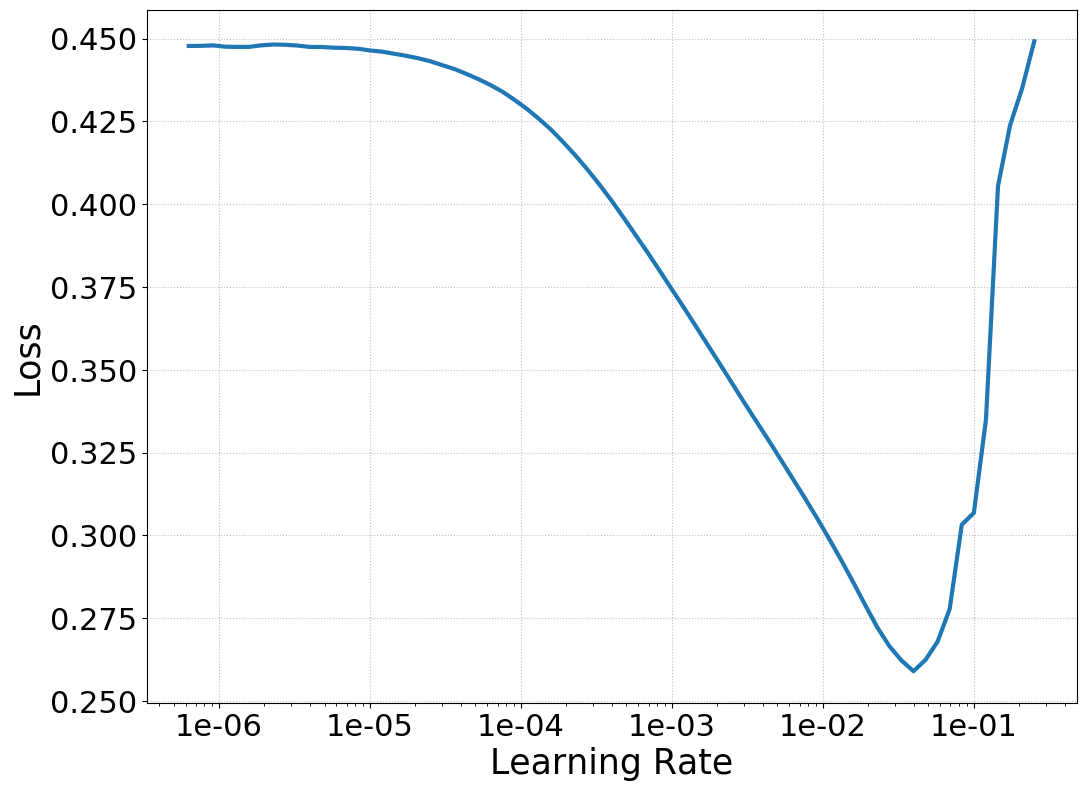

In [135]:
learn.recorder.plot()

In [136]:
lr = 3e-3
learn.fit_one_cycle(20, max_lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.003359,0.003094,03:16
1,0.001730,0.001553,03:35
2,0.001239,0.001023,03:17
3,0.000975,0.000904,03:15
4,0.000936,0.000638,03:13
5,0.001066,0.000724,03:06
6,0.000927,0.000557,03:05
7,0.000601,0.001257,03:10
8,0.000440,0.071410,03:05
9,0.000490,0.003513,03:07


In [24]:
ls models

200_custom_norm_over_night2.pth       best_bs2048_lr0.0001_wd0.1.pth
200_custom_norm_over_night_all.pth    best_bs2048_lr0.01_wd0.1.pth
200_custom_norm_over_night_all2.pth   tmp.pth
27-400-400-200-18-200-400-400-27.pth


In [25]:
pwd

'/Users/ericwulff/Documents/LTH/Examensarbete/lth_thesis_project/jet_by_jet_compression/aod_compression'

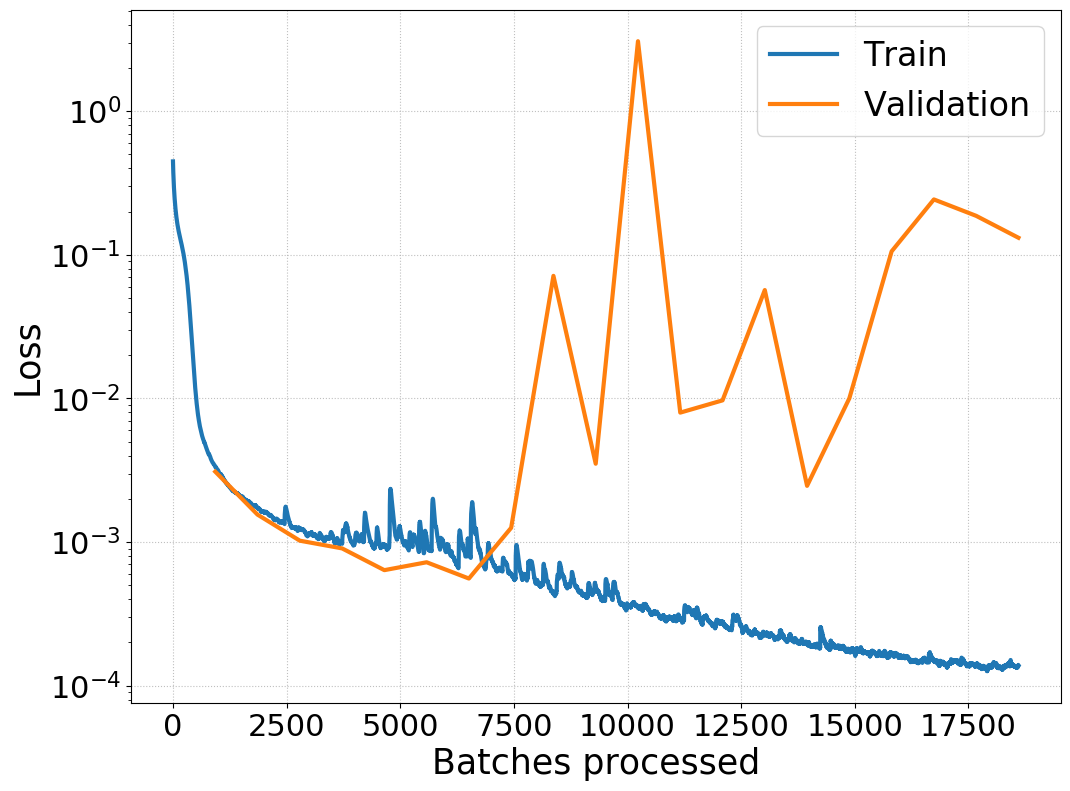

In [137]:
learn.recorder.plot_losses()
plt.yscale('log')

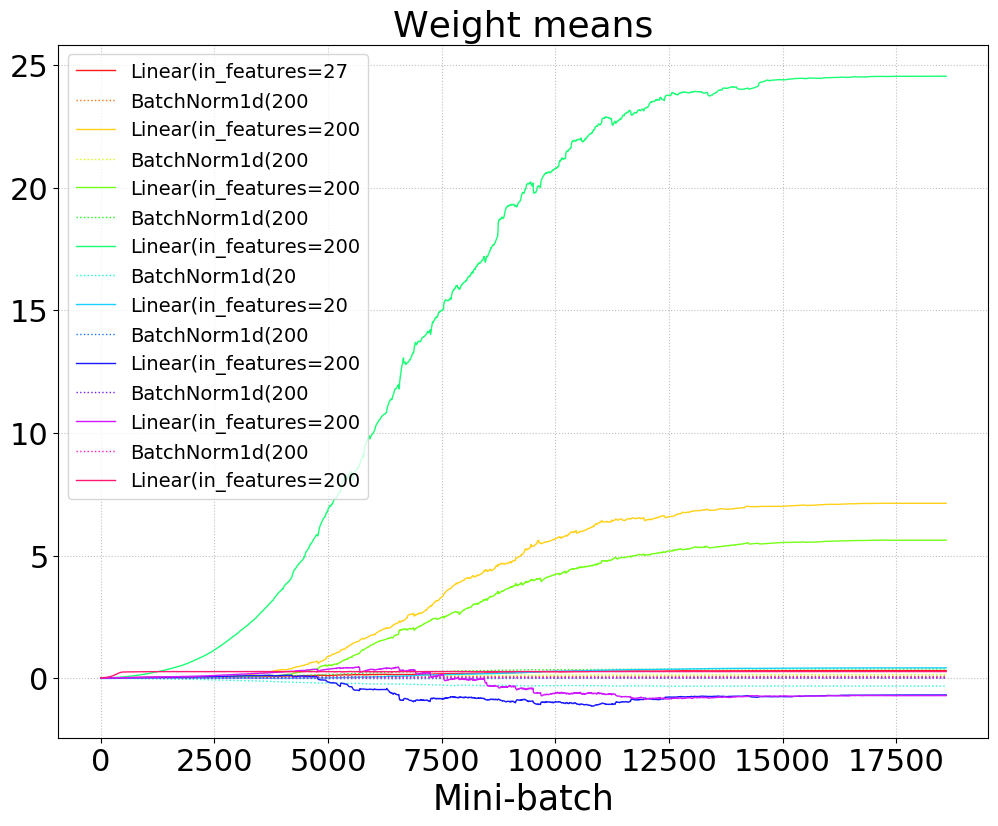

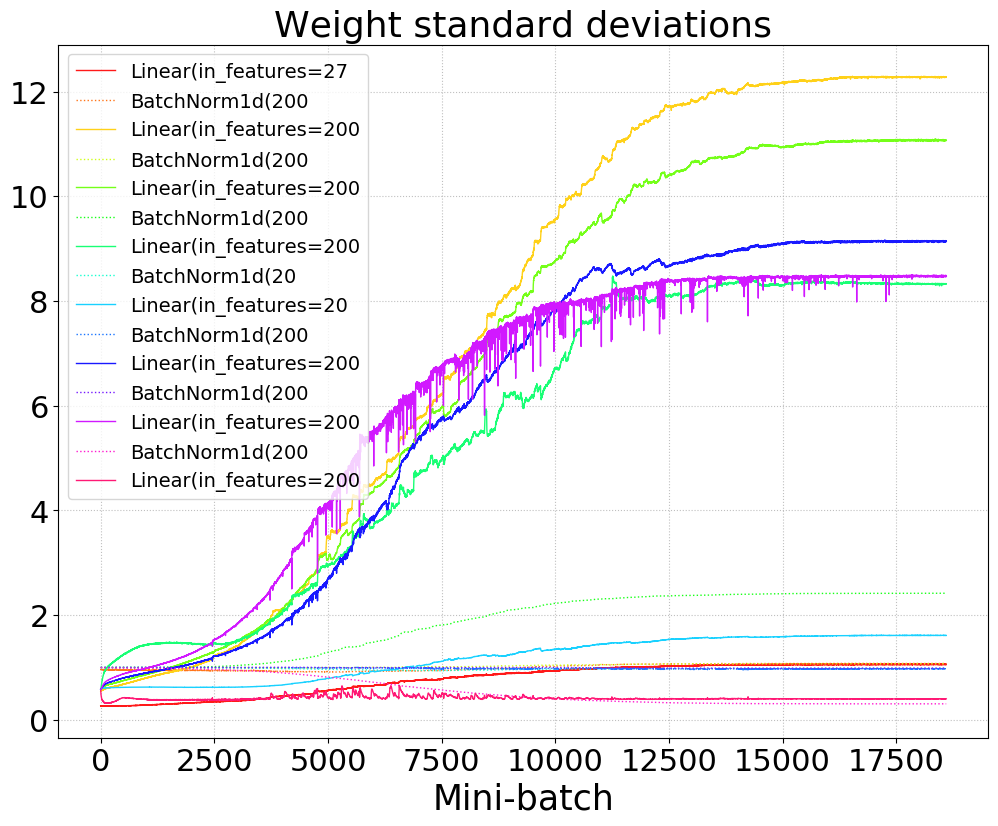

In [138]:
import utils
utils.plot_activations(learn)

In [ ]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(custom_normalized_test[idxs[0]:idxs[1]].values, dtype=torch.float)
pred = model(data).detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=test.columns)
pred_df = pd.DataFrame(pred, columns=test.columns)

unnormalized_data_df = custom_unnormalize(data_df)
unnormalized_pred_df = custom_unnormalize(pred_df)
unnormalized_pred_df['N90Constituents'] = unnormalized_pred_df['N90Constituents'].round()

In [ ]:
def round_to_input(pred, uniques, variable):
    var = pred[variable].values.reshape(-1, 1)
    diff = (var - uniques)
    ind = np.apply_along_axis(lambda x: np.argmin(np.abs(x)), axis=1, arr=diff)
    new_arr = -np.ones_like(var)
    for ii in np.arange(new_arr.shape[0]):
        new_arr[ii] = uniques[ind[ii]]
    pred[variable] = new_arr

In [ ]:
uniques = unnormalized_data_df['ActiveArea'].unique()
round_to_input(unnormalized_pred_df, uniques, 'ActiveArea')

(array([1., 0., 0., 0., ..., 0., 0., 0., 2.]),
 array([0.08825 , 0.088413, 0.088577, 0.08874 , ..., 0.904856, 0.905019, 0.905183, 0.905346]),
 <a list of 5000 Patch objects>)

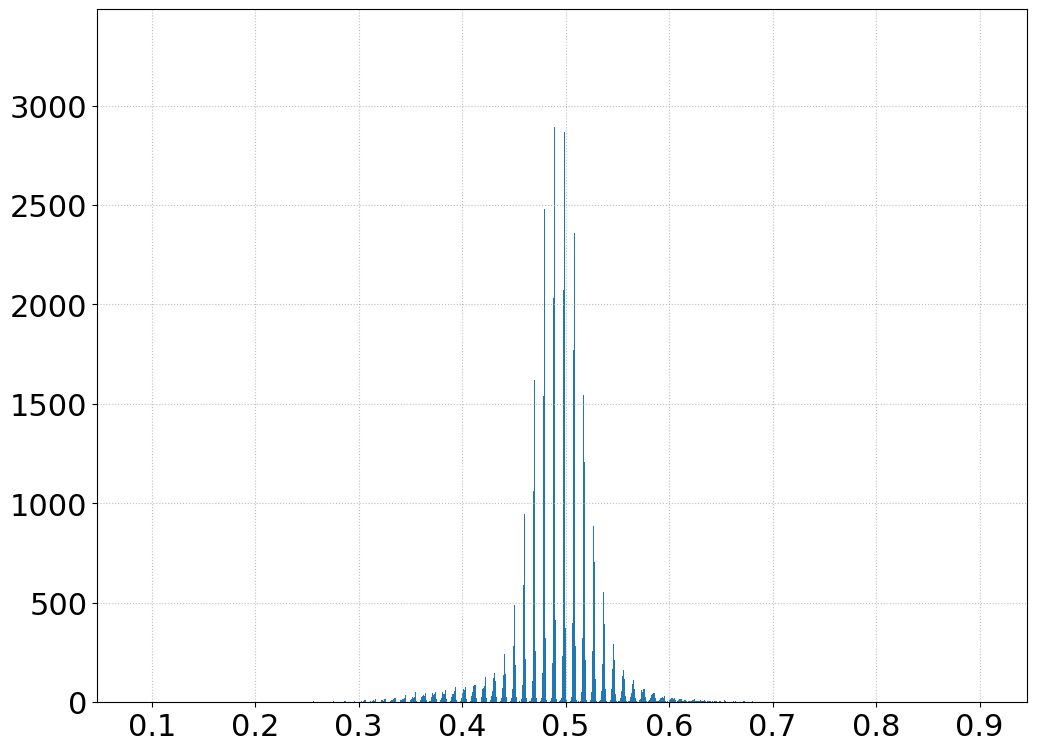

In [27]:
plt.hist(test['ActiveArea4vec_pt'], bins=5000)

In [52]:
plt.close('all')

/Users/ericwulff/miniconda3/envs/fastairoot/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


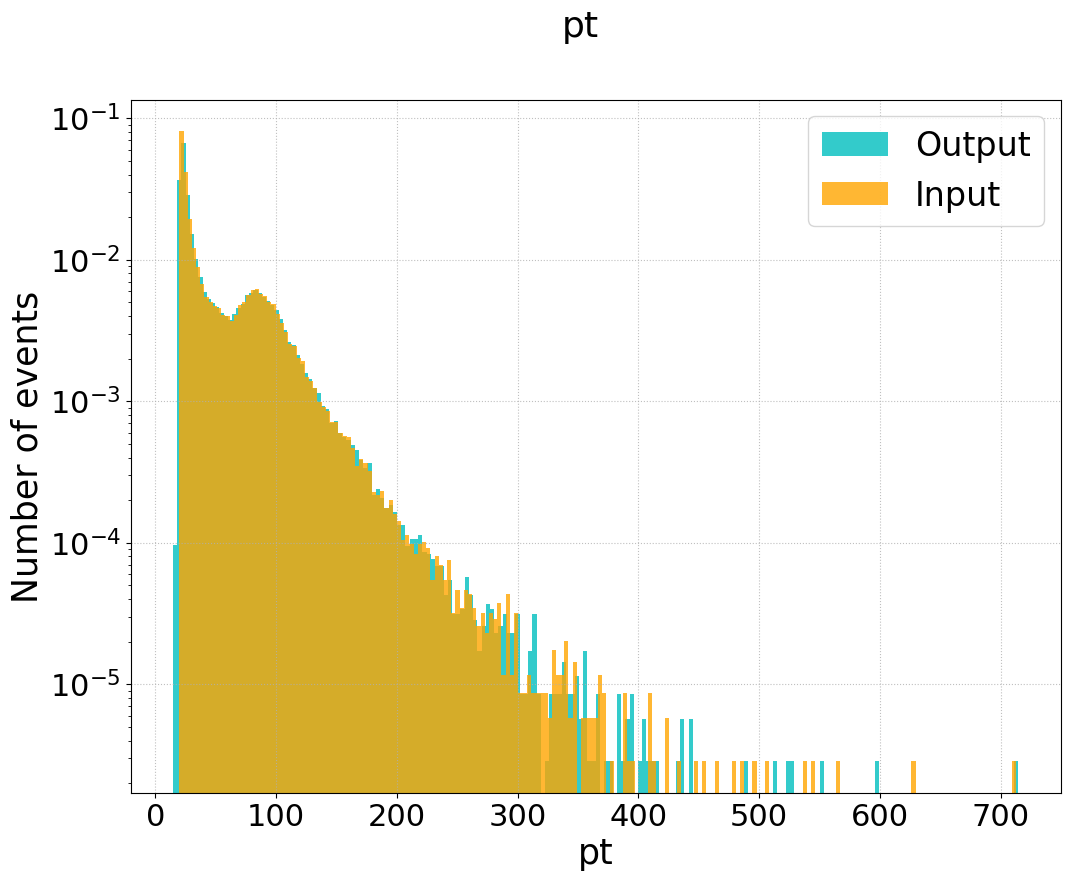

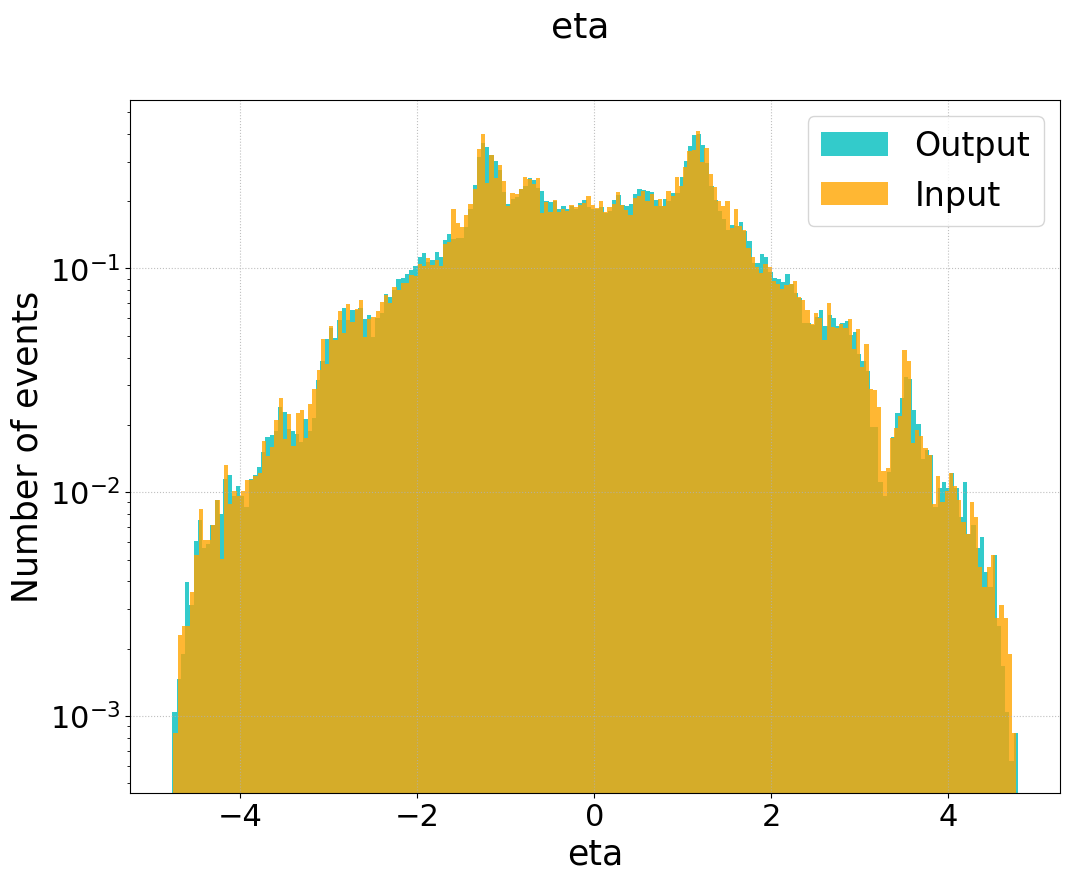

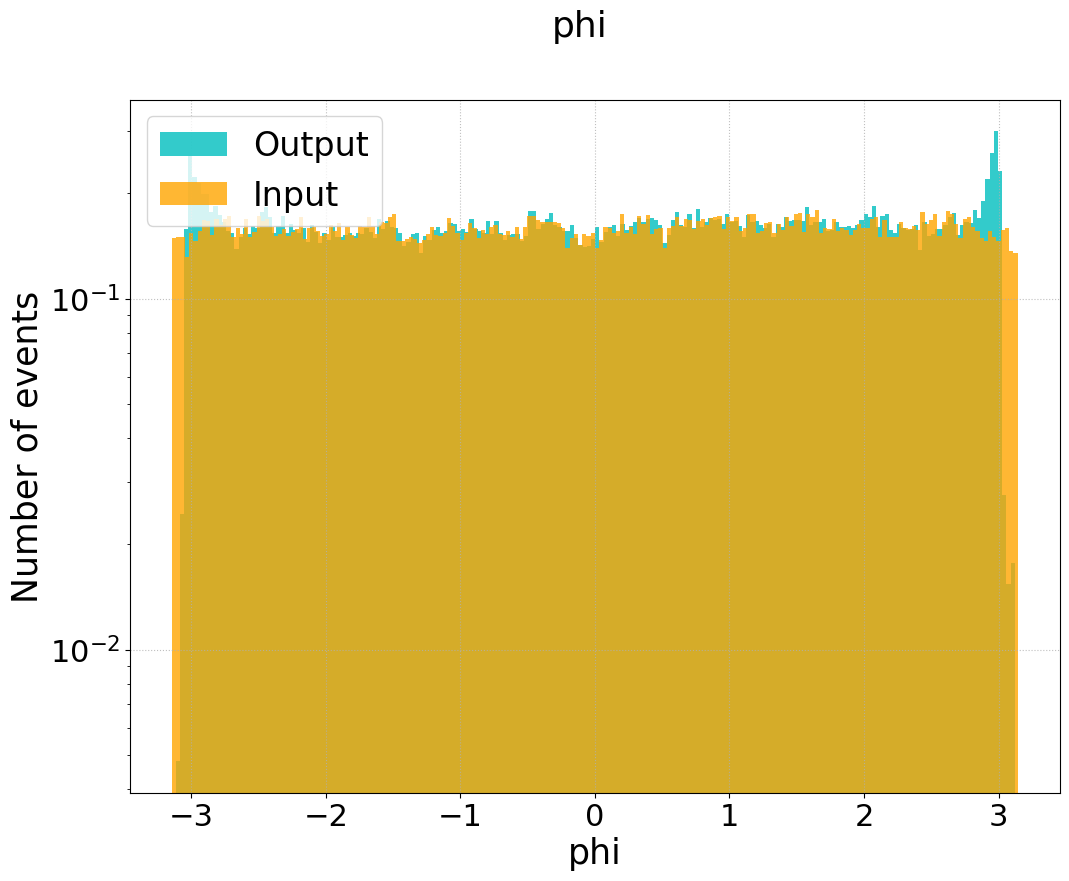

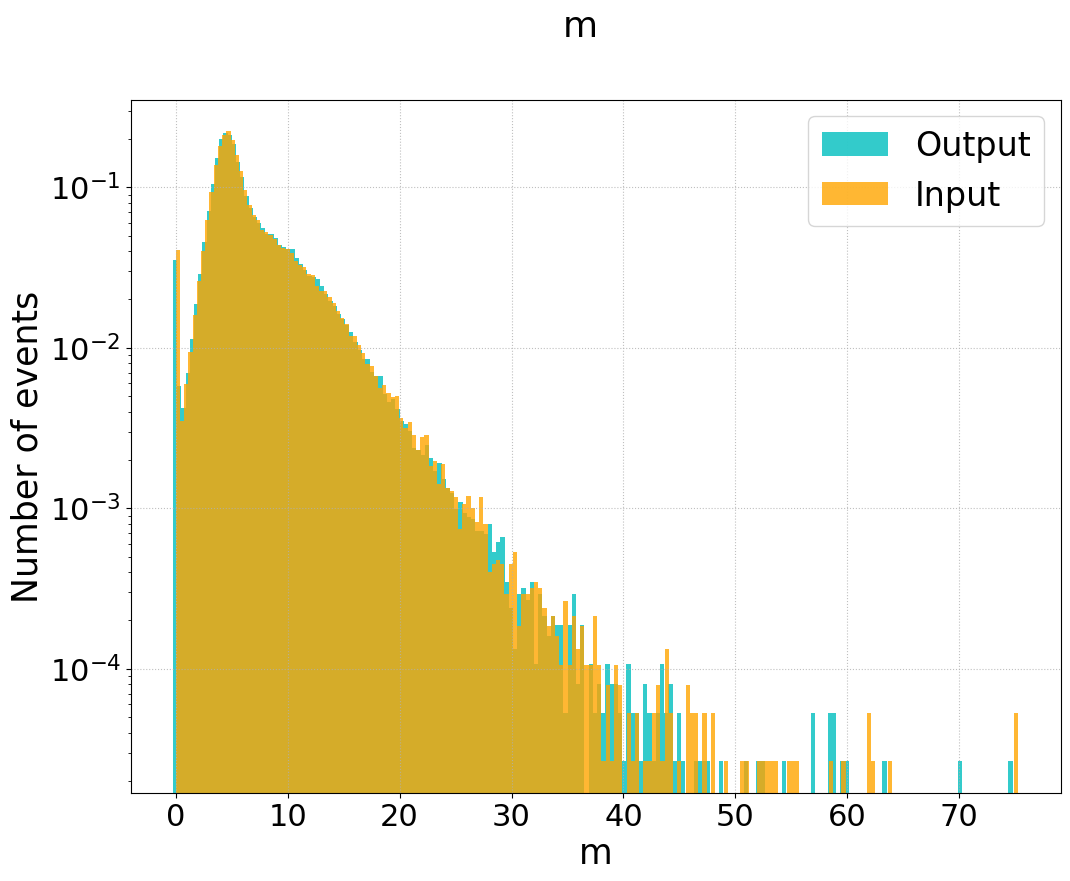

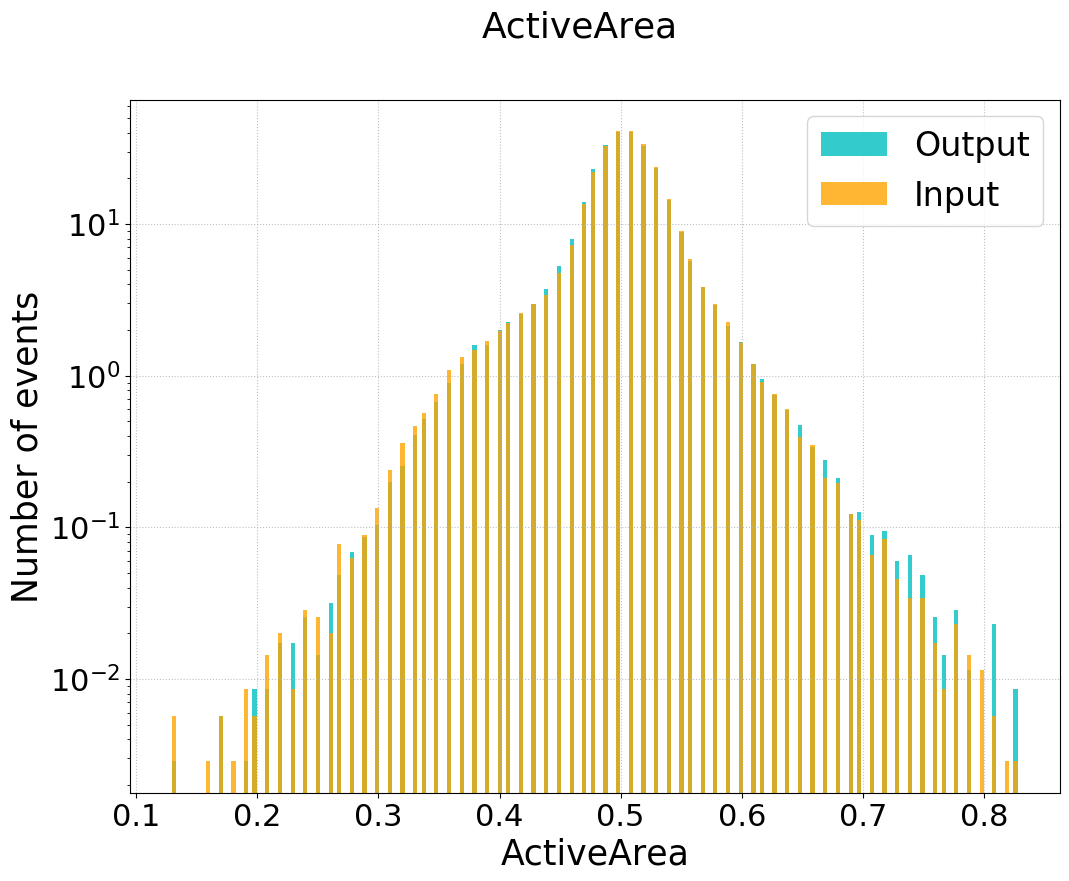

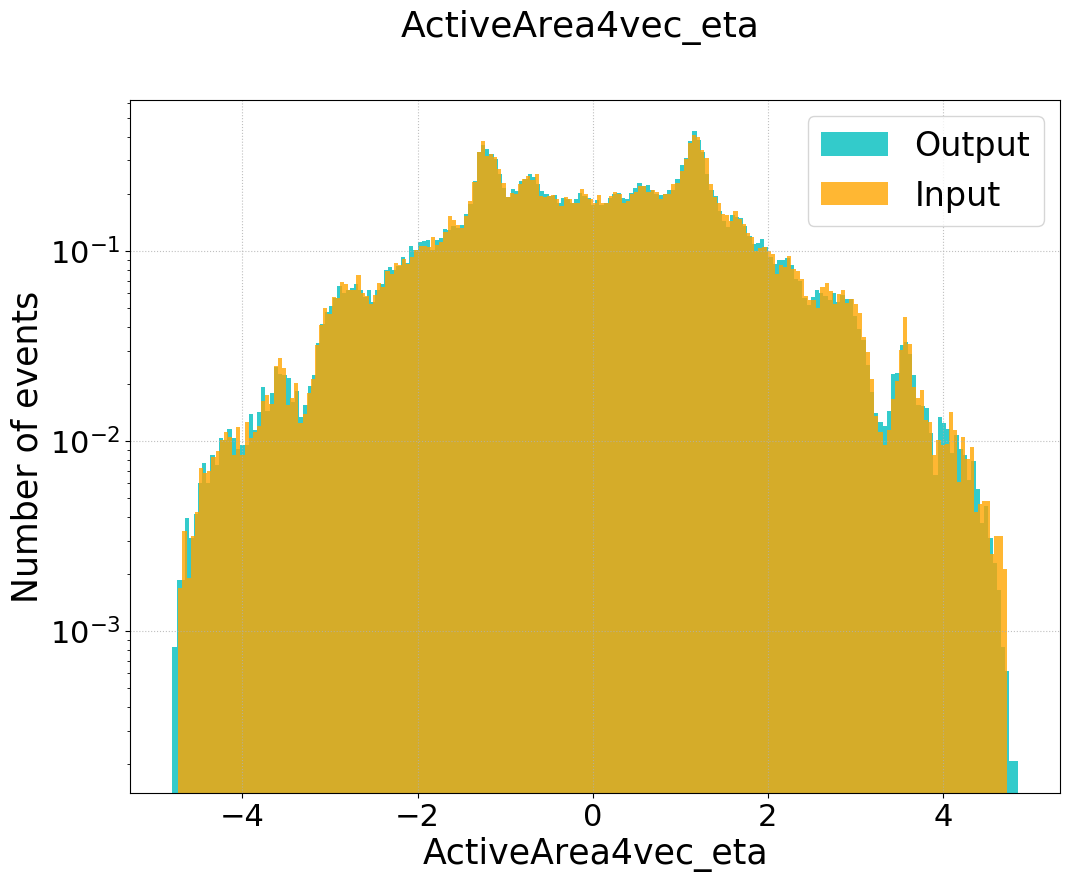

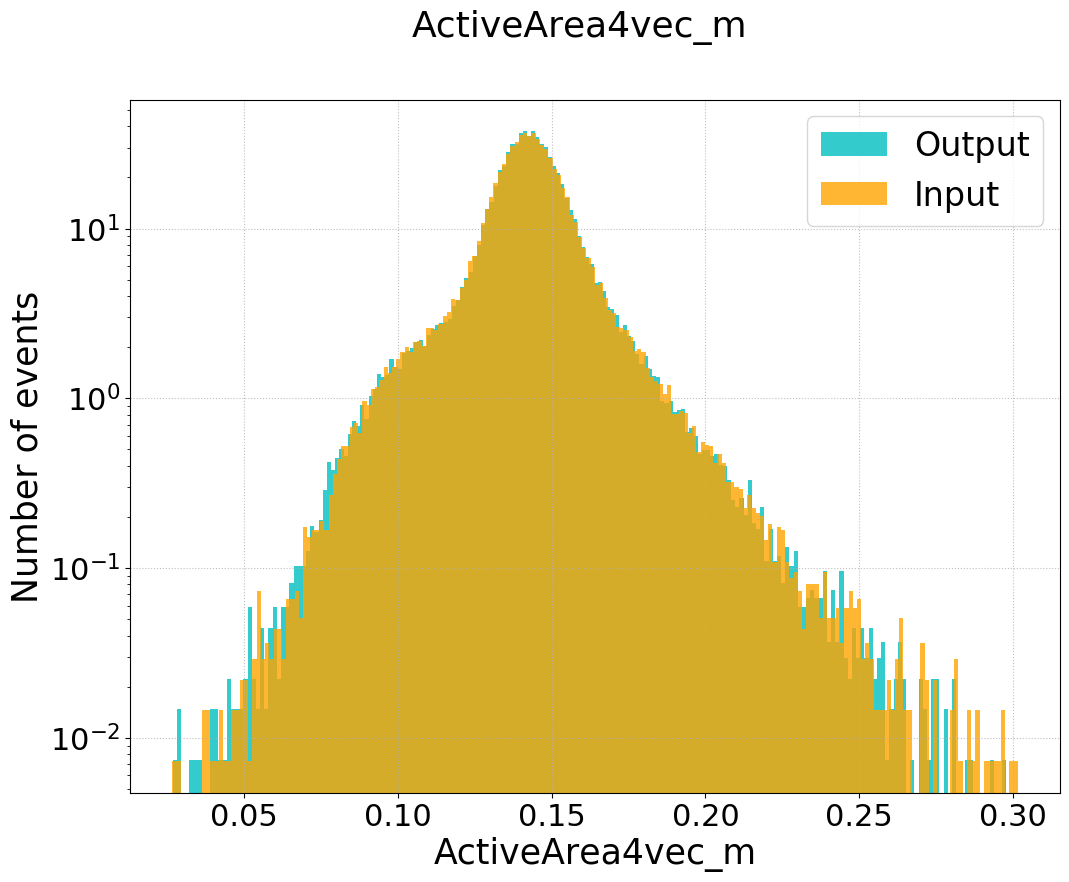

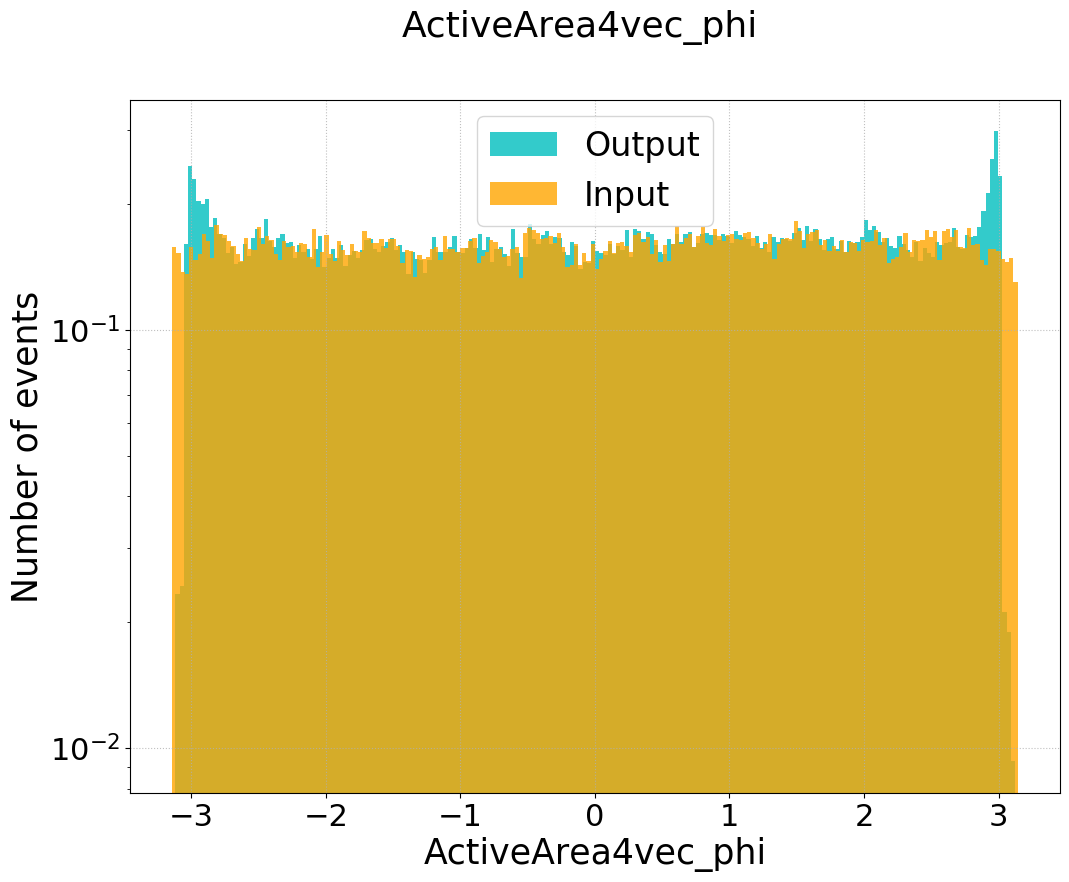

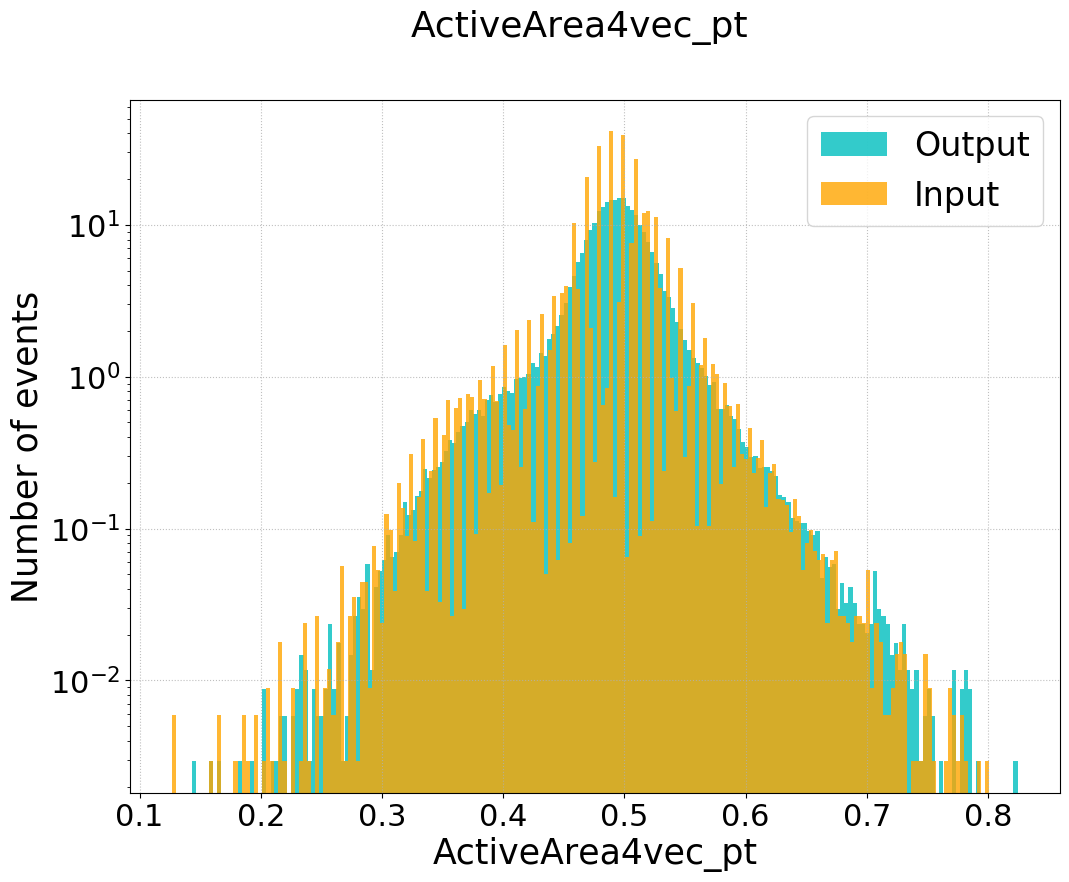

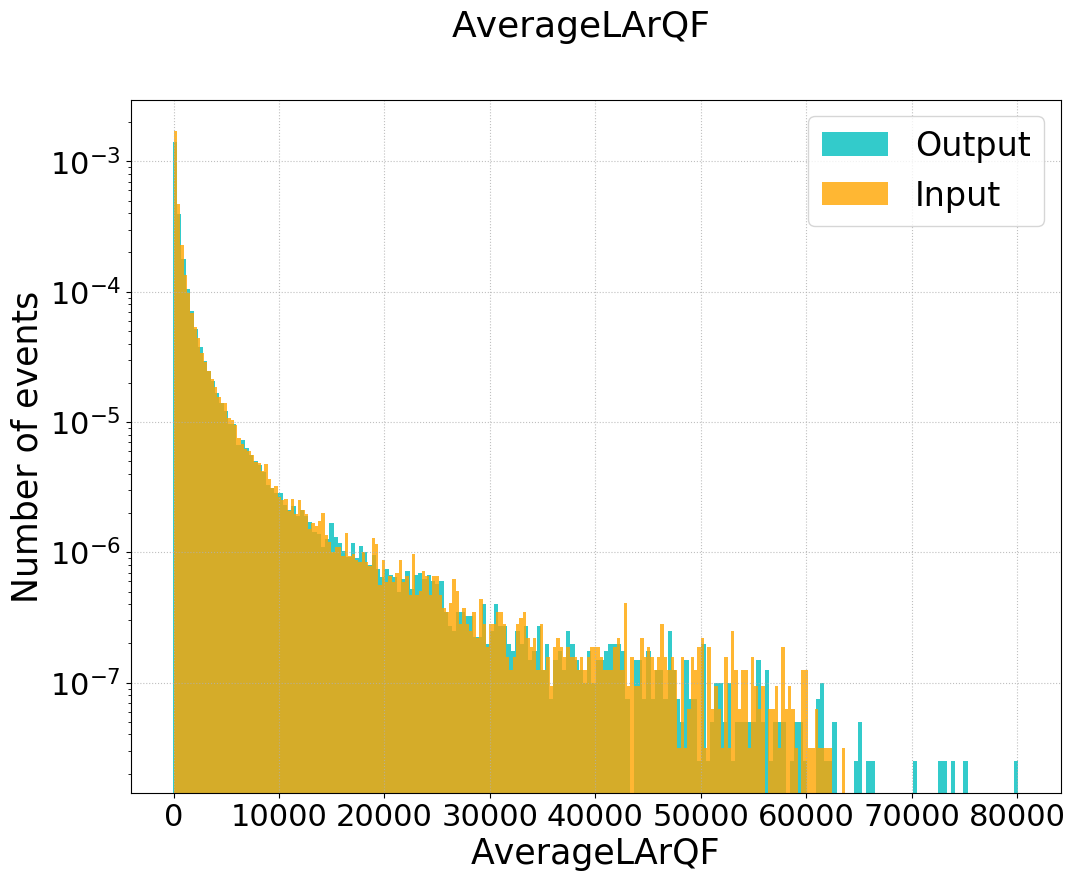

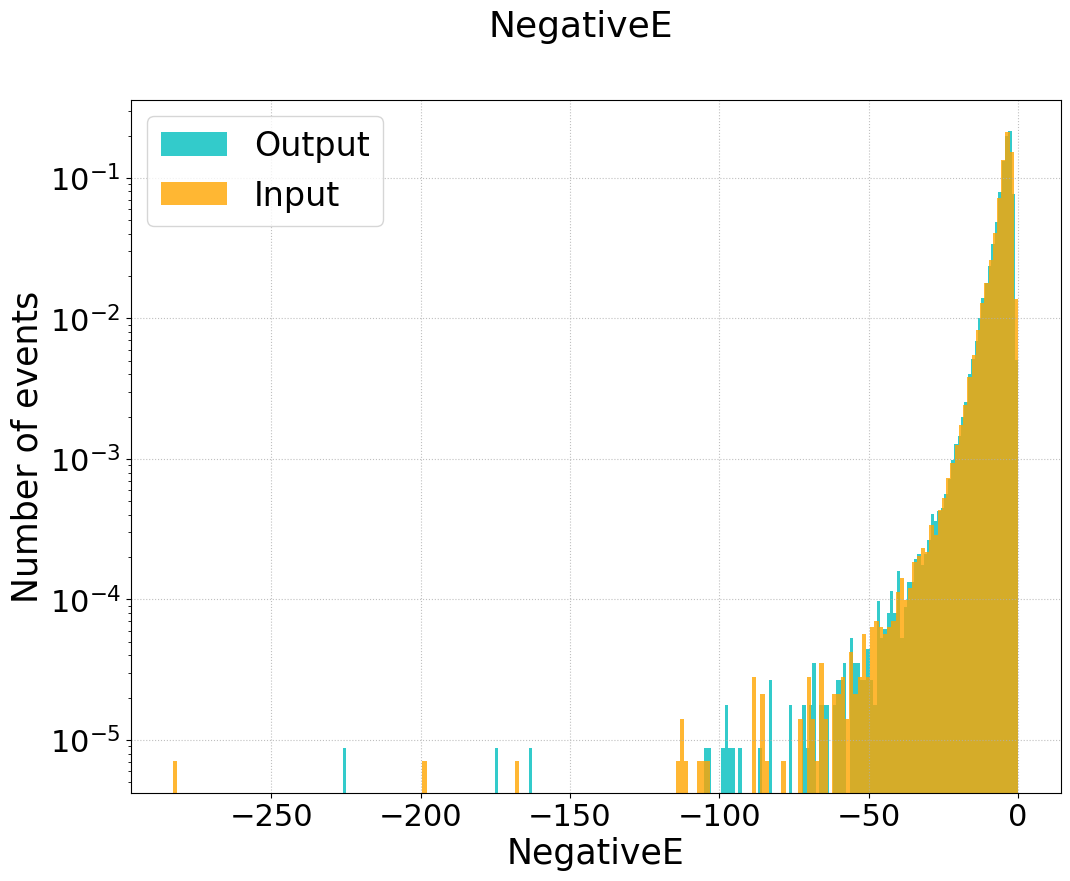

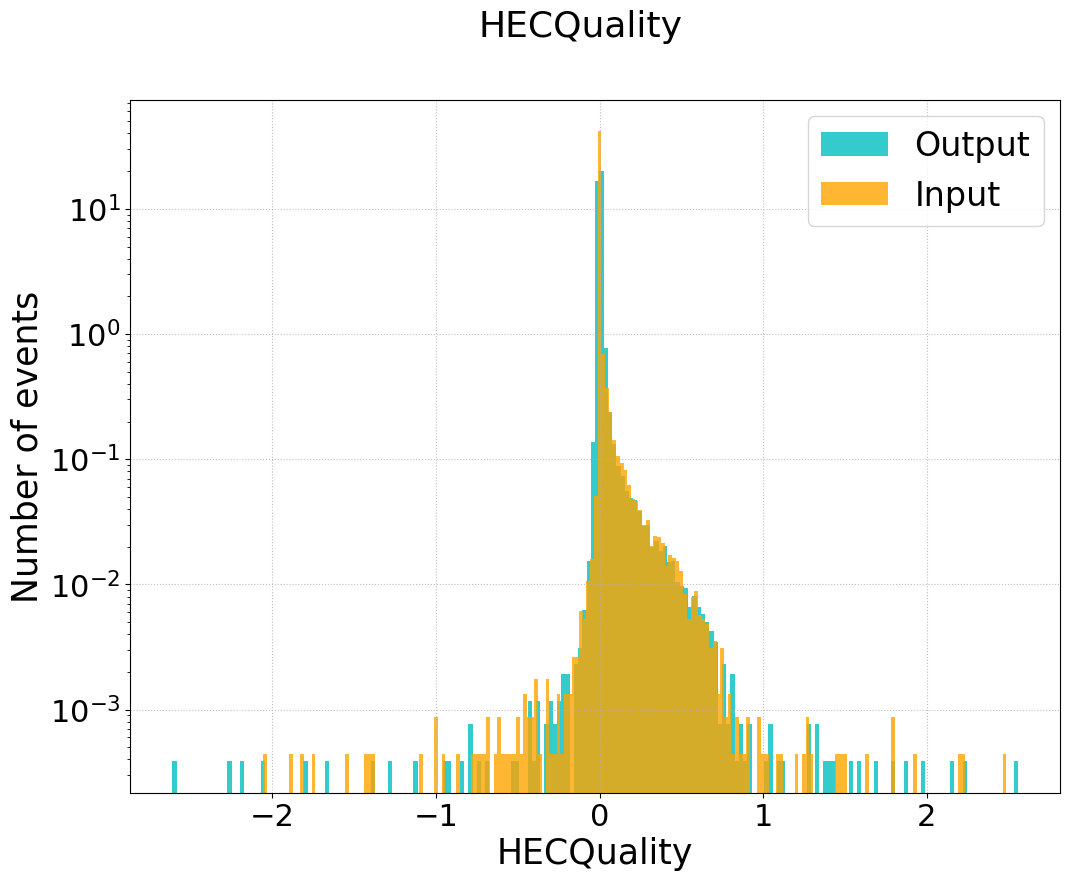

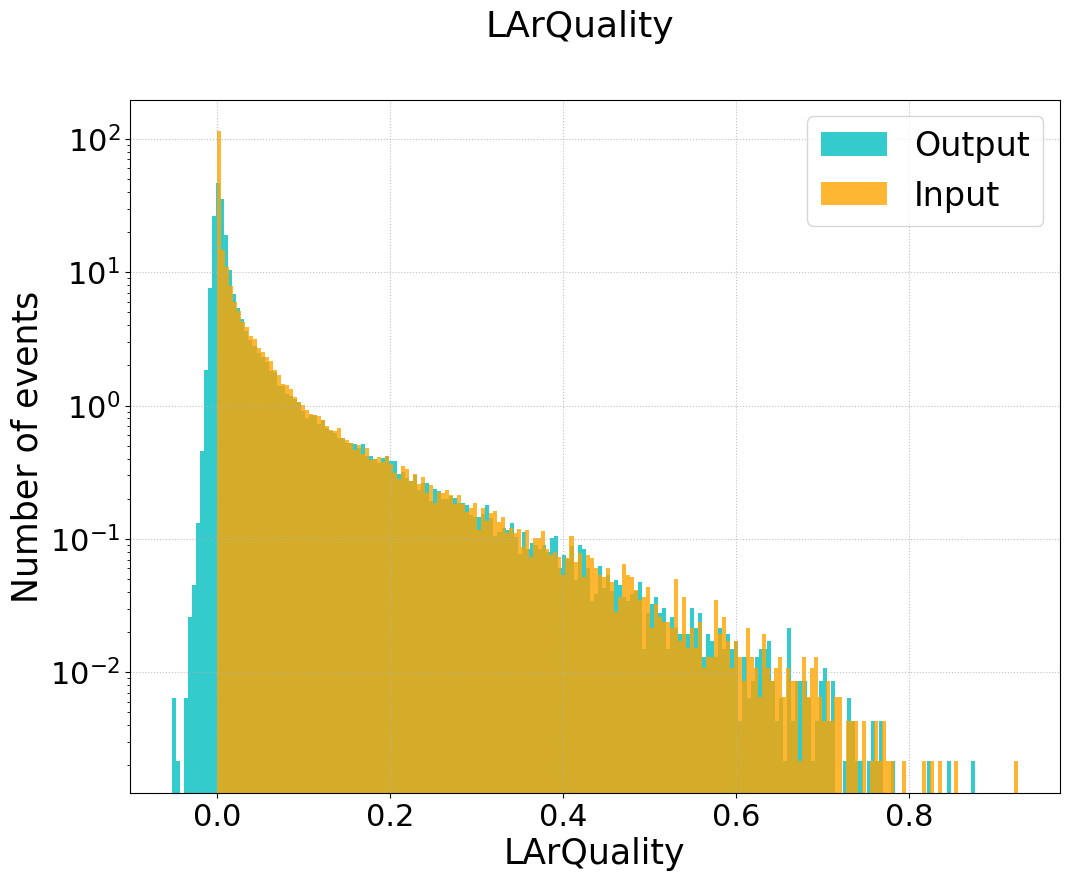

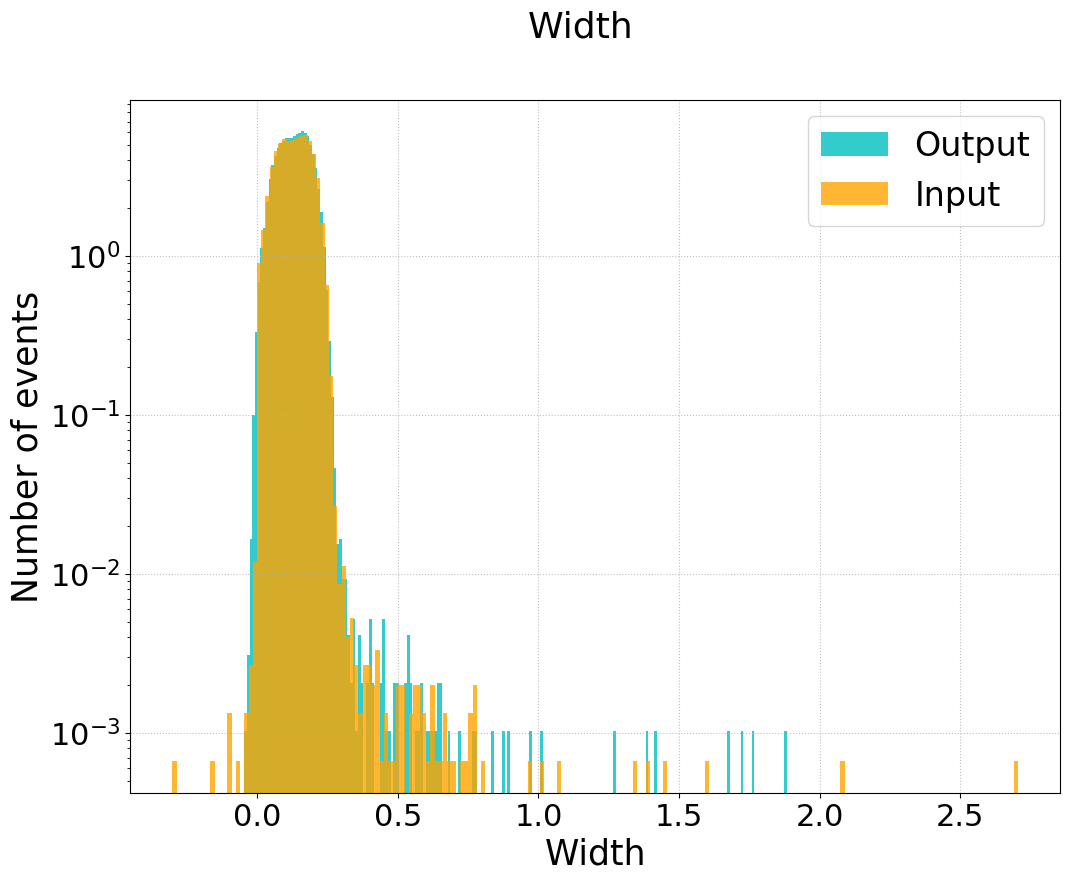

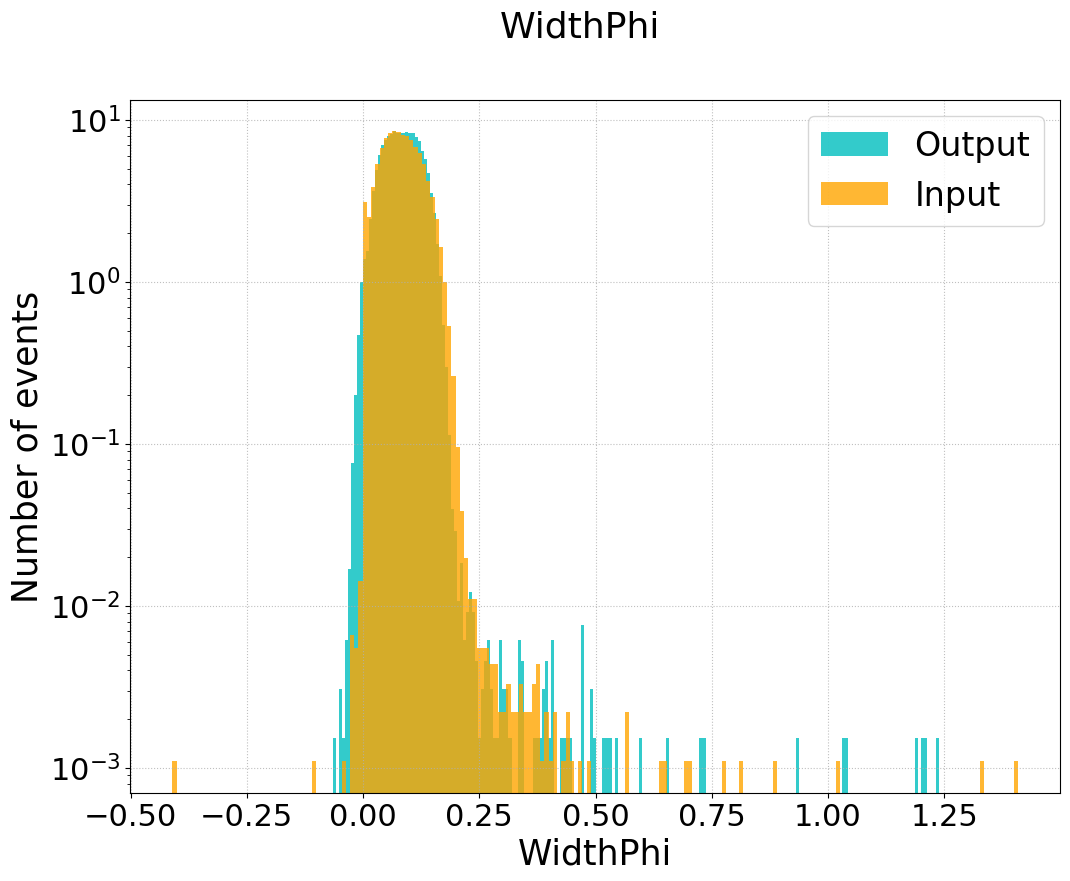

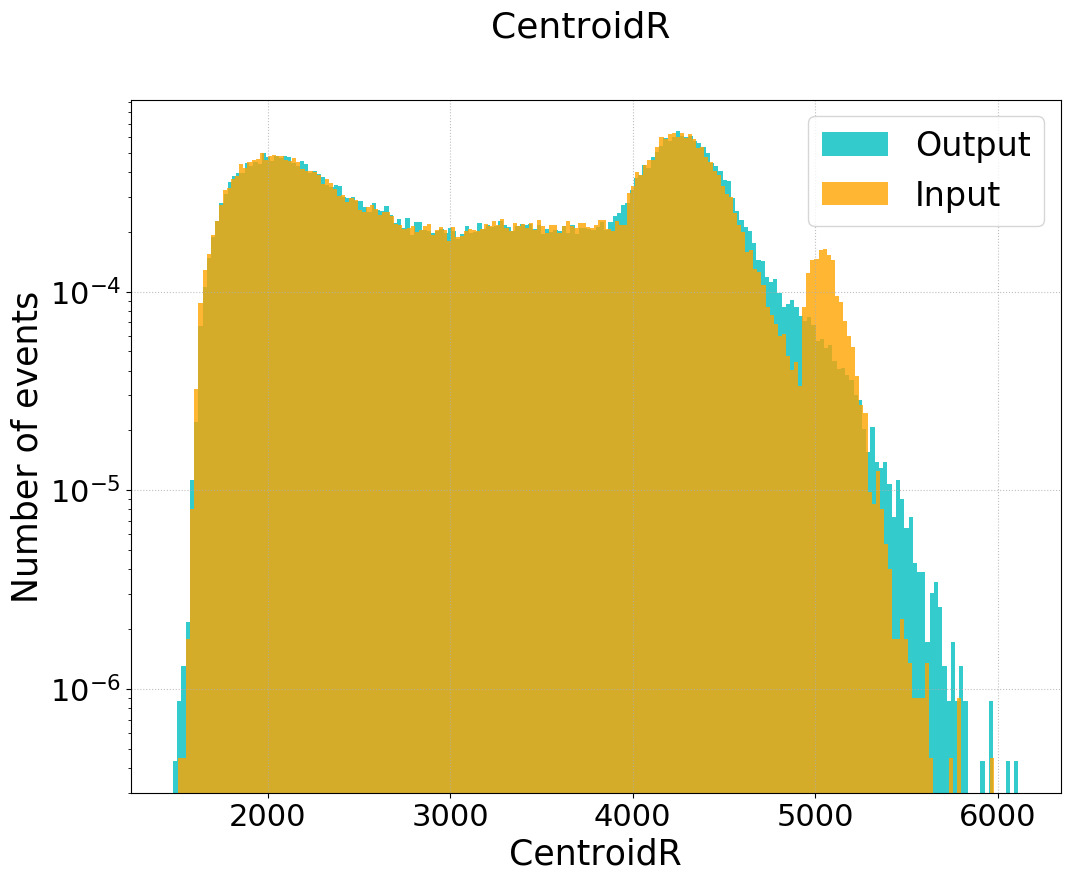

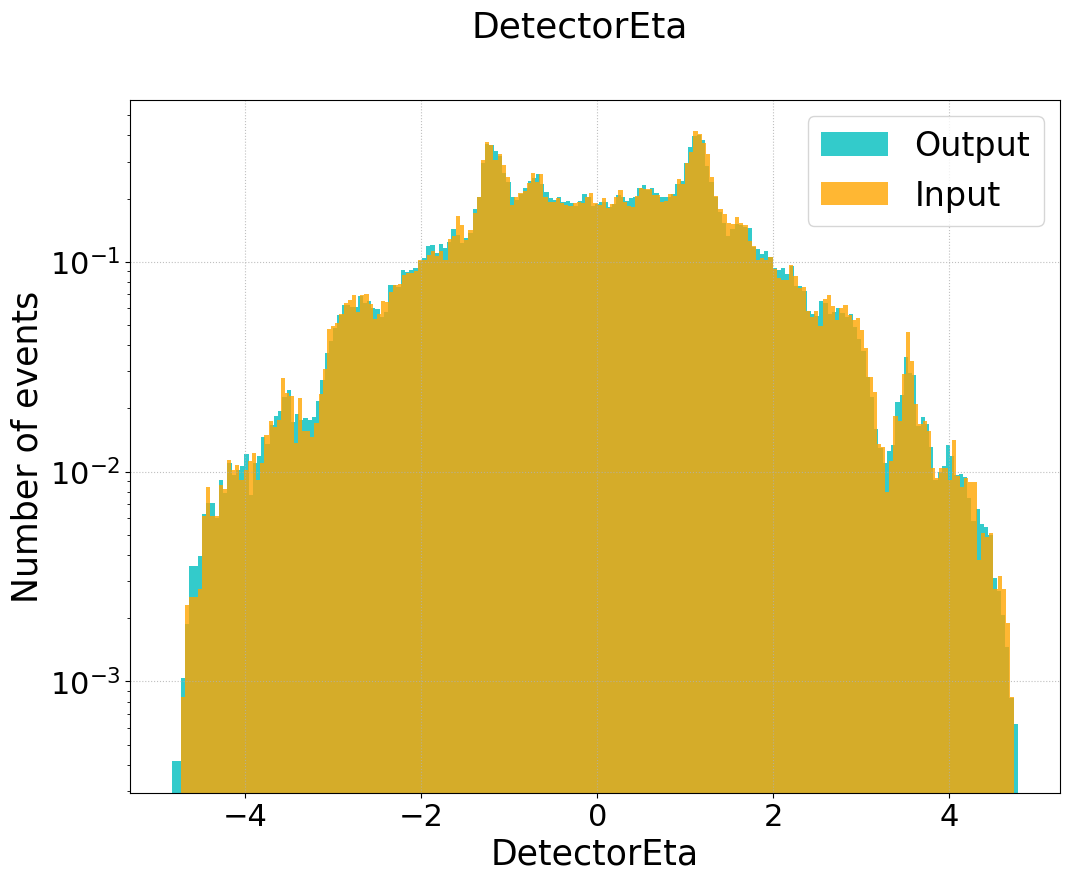

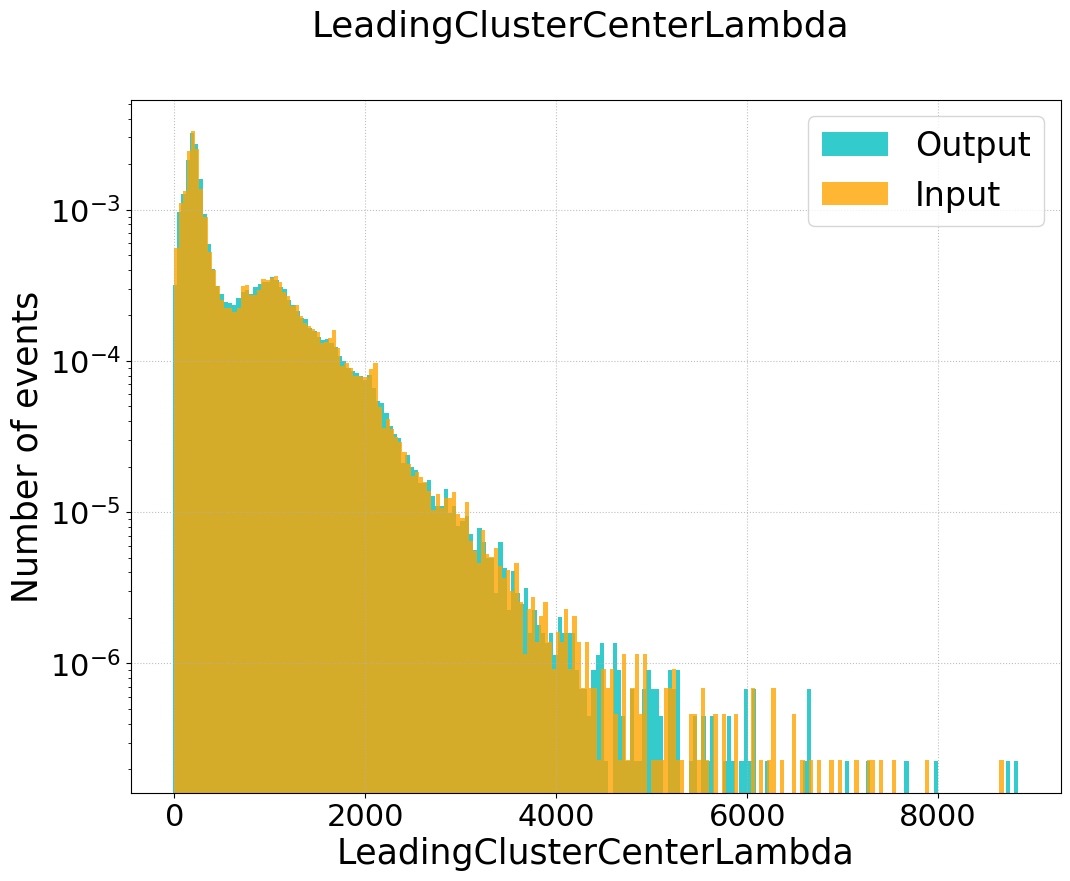

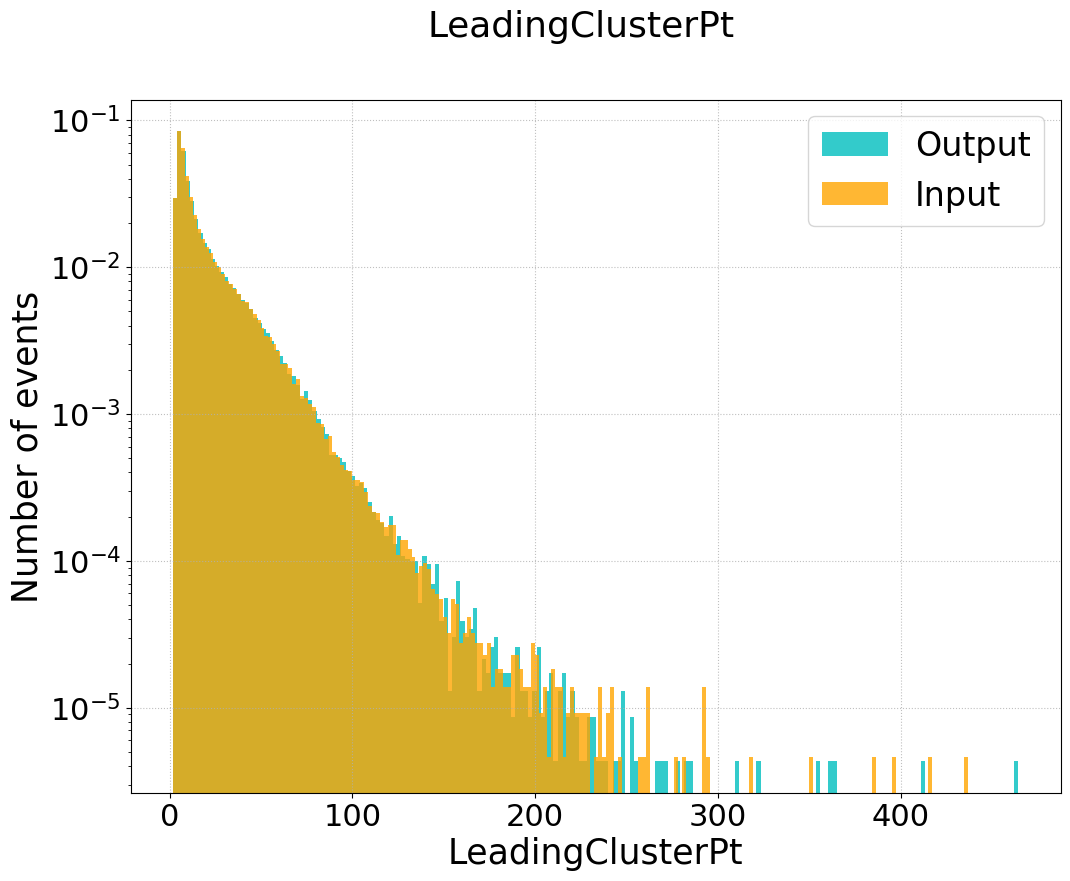

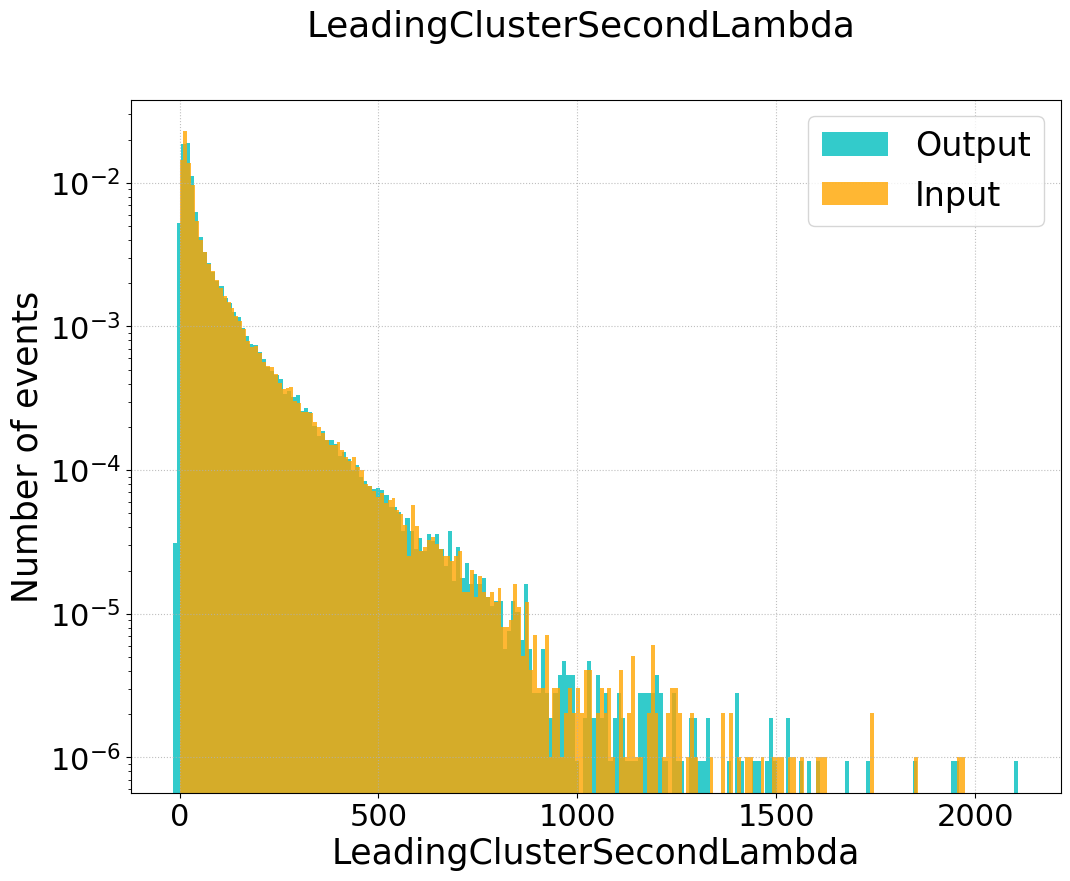

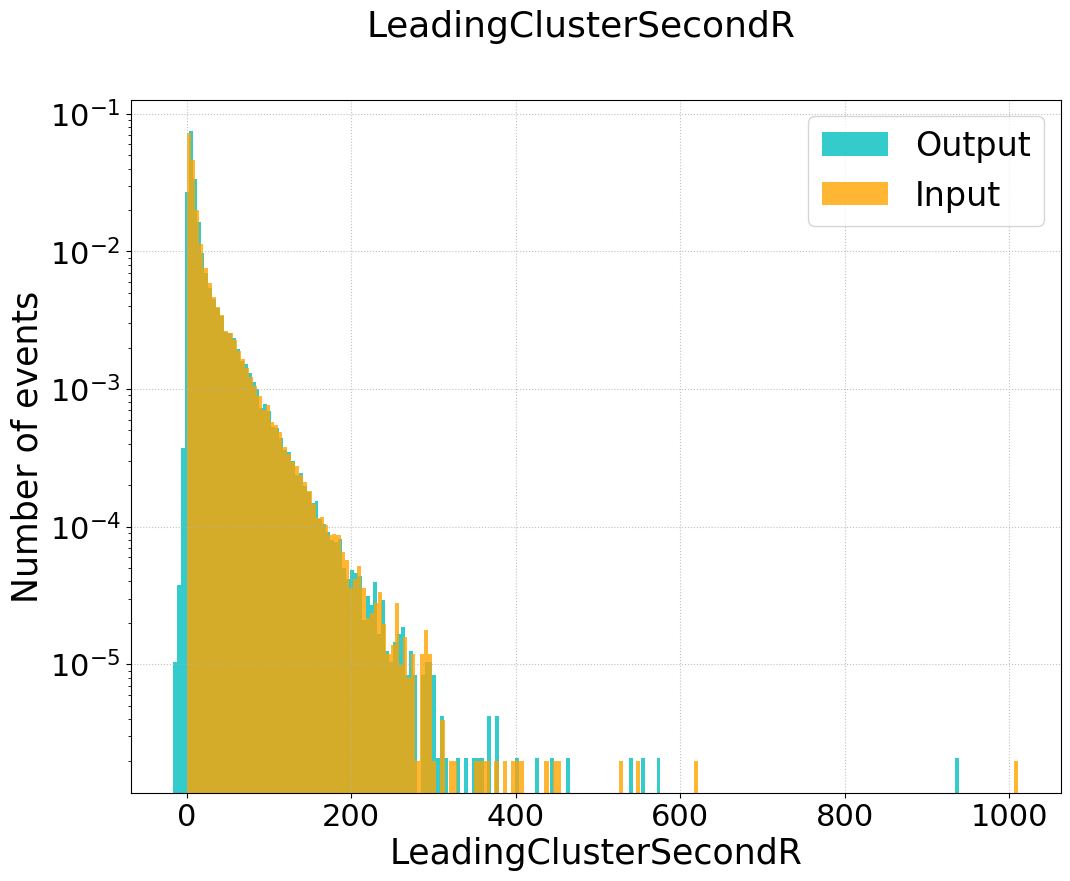

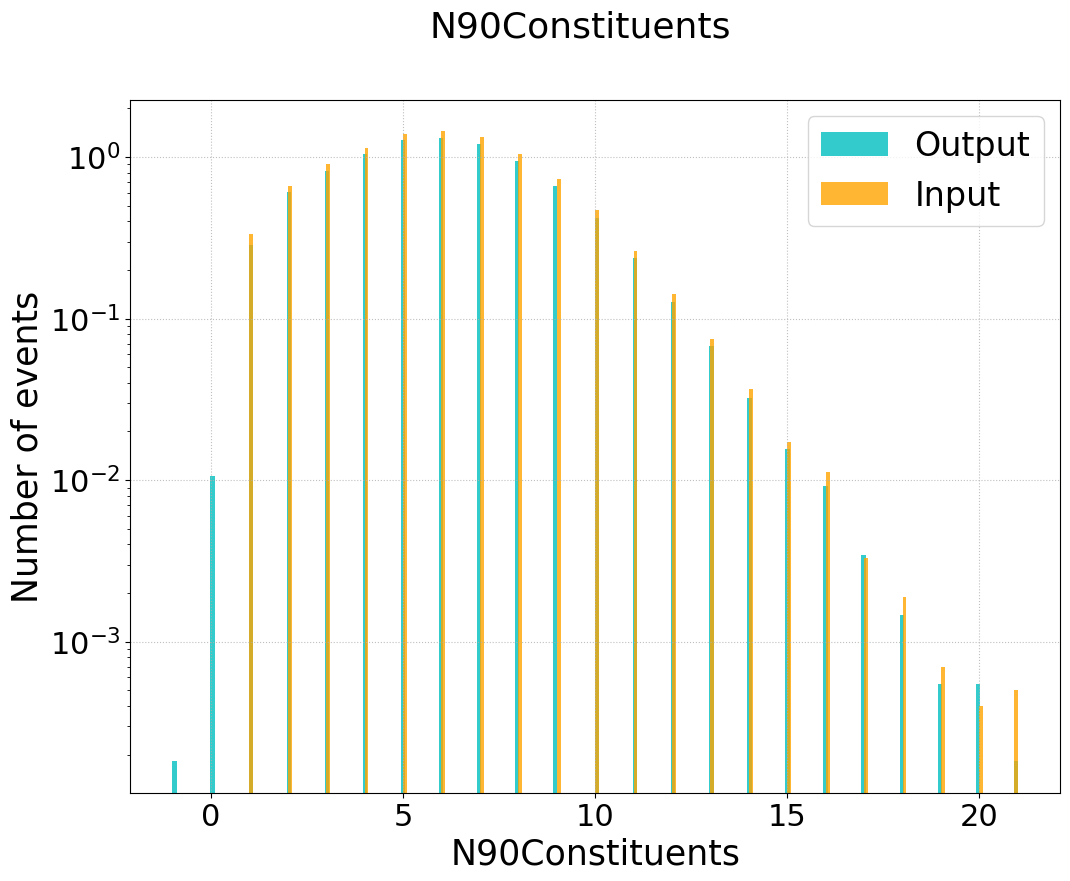

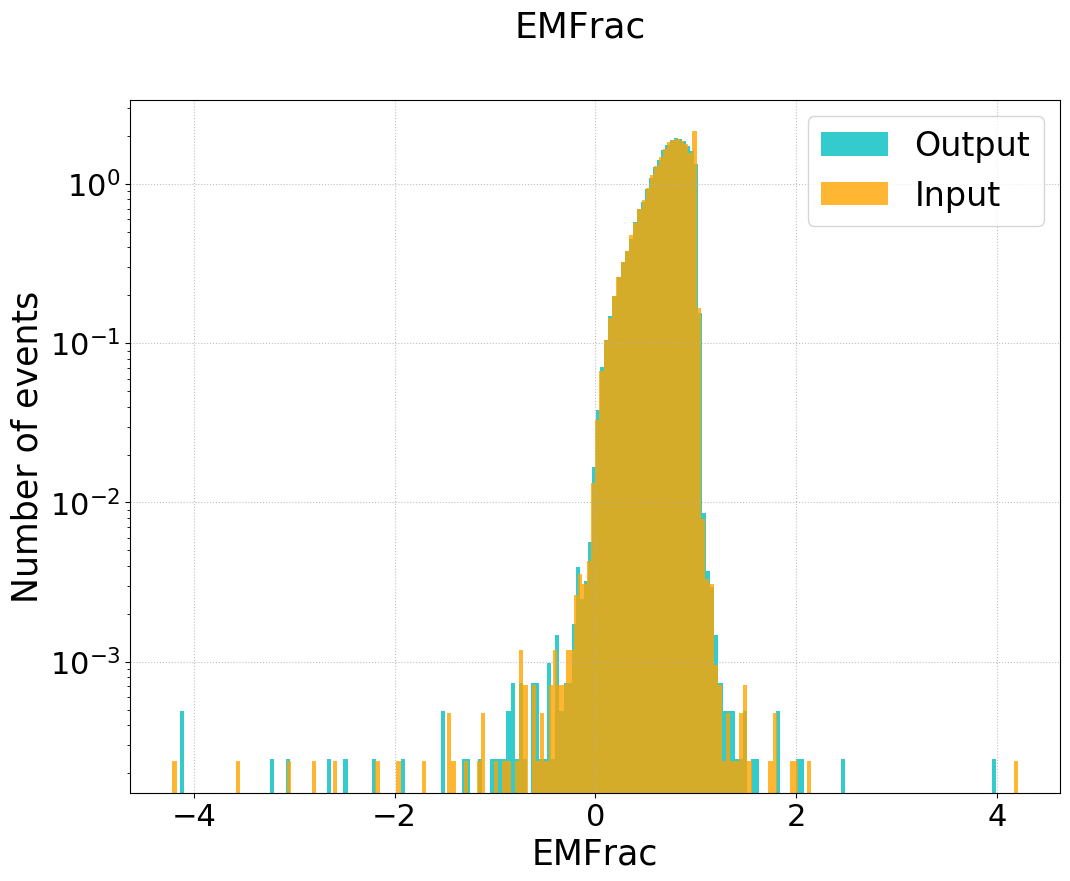

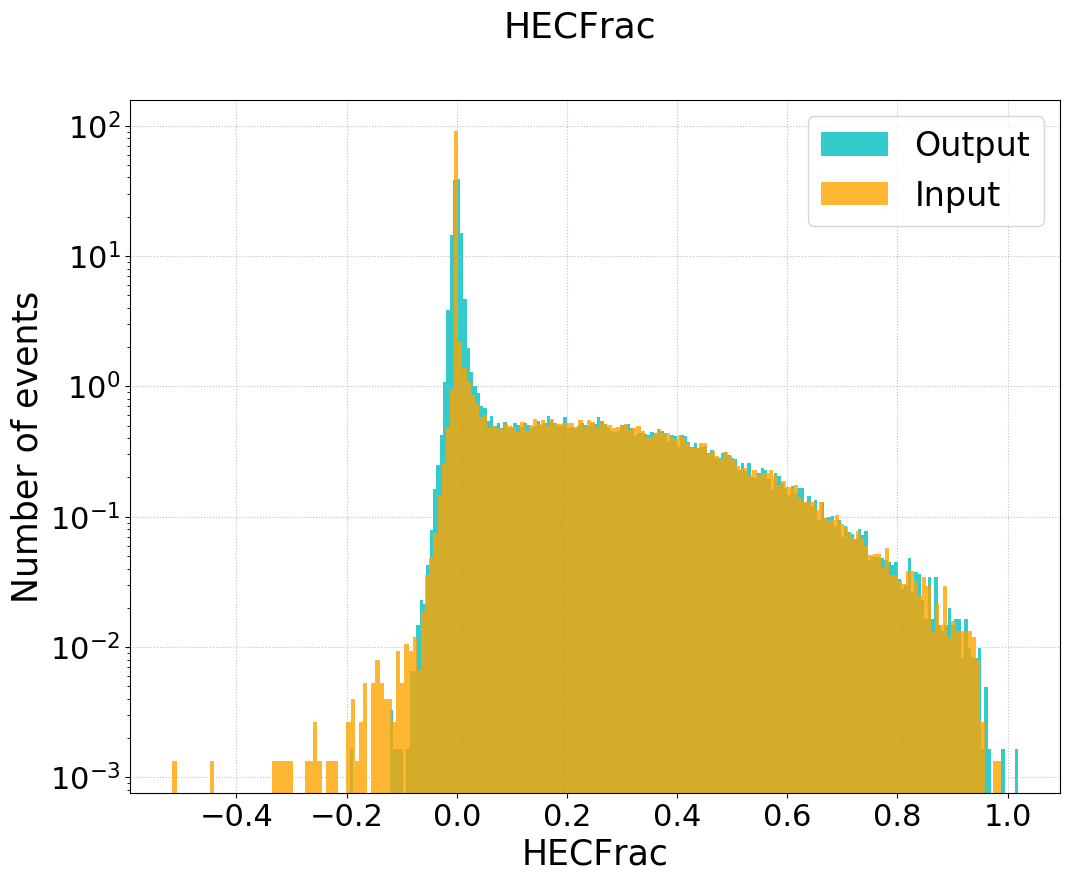

In [139]:
data = unnormalized_data_df.values
pred = unnormalized_pred_df.values

alph = 0.8
n_bins = 200
for kk in np.arange(24):
    plt.figure()
    n_hist_pred, bin_edges, _ = plt.hist(pred[:, kk], color=colors[1], label='Output', alpha=alph, bins=n_bins, density=True)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[0], label='Input', alpha=alph, bins=n_bins, density=True)
    plt.suptitle(test.columns[kk])
    plt.xlabel(test.columns[kk])
    plt.ylabel('Number of events')
    #ms.sciy()
    plt.yscale('log')
    plt.legend()